In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation_Test import sys_dataset

# Varying sigma of spatial model

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

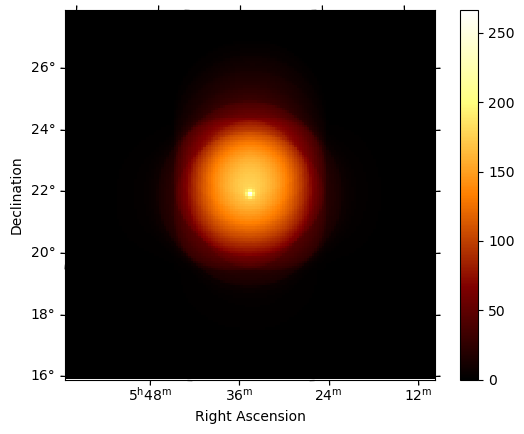

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1"
)

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Varying the Exposure

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

# energy independent method: pm 10% for reconstructed energy
shift_neg = -0.1 #-0.085
shift_pos = 0.1 #0.085
shift_cor = 0.0

tilt_neg = -0.015 # 1e-25 for computational purposes -> covmatrix "1/0"
tilt_pos = 0.015
tilt_cor = 0.0

### Varying sigma_spatial

In [5]:
%%time
amplitude_sigma_spatial = []
index_sigma_spatial = []
lambda_sigma_spatial = []
norm_sigma_spatial = []
errors_amplitude_sigma_spatial = []
errors_index_sigma_spatial = []
errors_lambda_sigma_spatial = []
errors_norm_sigma_spatial = []

amplitude_sigma_spatial_fail = []
index_sigma_spatial_fail = []
lambda_sigma_spatial_fail = []
norm_sigma_spatial_fail = []
errors_amplitude_sigma_spatial_fail = []
errors_index_sigma_spatial_fail = []
errors_lambda_sigma_spatial_fail = []
errors_norm_sigma_spatial_fail = []

shift_fixed = 0.085
tilt_fixed = 0.015
amplitude = 1e-12

for i, sigma_spatial in enumerate(np.linspace(0.0001, 0.25, 60)):
    print('sigma_spatial', i, '=', sigma_spatial)
    
    dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
    # Create the spatial model 
    model_spatial = GaussianSpatialModel(
        lon_0="83.631 deg",
        lat_0="22.018 deg",
        sigma=f"{sigma_spatial} deg",
        )

    # Create the spectral model 
    model_spectrum  = ExpCutoffPowerLawSpectralModel(
        index=2.3,
        amplitude=f"{amplitude} TeV-1 cm-2 s-1",
        lambda_="0.1 TeV-1"
    )

    # combine the spectral and the spatial model
    source_model = SkyModel(spatial_model = model_spatial ,
                           spectral_model = model_spectrum,
                           name = "Source")    
    models = Models(source_model)

    # Create the model for the Background
    bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
    bkg_model.parameters['tilt'].frozen  = False
    models.append(bkg_model)

    # set the models in the dataset
    dataset_asimov.models = models
    # set counts
    dataset_asimov.counts = dataset_asimov.npred()
    
    
    sys_d = sys_dataset(dataset_asimov, shift_fixed, tilt_fixed, False, amplitude, sigma_spatial)
    dataset_sigma_spatial = sys_d.create_dataset()
    fit_sigma_spatial = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_sigma_spatial.backend = "minuit"
    fit_sigma_spatial.optimize_opts = minuit_opts
    result_sigma_spatial = fit_sigma_spatial.run([dataset_sigma_spatial])
    
    
    if result_sigma_spatial.success:
        #print(result_sigma_spatial.success)
        amplitude_sigma_spatial.append((sigma_spatial, dataset_sigma_spatial.models.parameters['amplitude'].value))
        index_sigma_spatial.append((sigma_spatial, dataset_sigma_spatial.models.parameters['index'].value))
        lambda_sigma_spatial.append((sigma_spatial, dataset_sigma_spatial.models.parameters['lambda_'].value))
        norm_sigma_spatial.append((sigma_spatial, dataset_sigma_spatial.models.parameters['norm'].value))

        errors_amplitude_sigma_spatial.append((sigma_spatial, dataset_sigma_spatial.models.parameters['amplitude'].error))
        errors_index_sigma_spatial.append((sigma_spatial, dataset_sigma_spatial.models.parameters['index'].error))
        errors_lambda_sigma_spatial.append((sigma_spatial, dataset_sigma_spatial.models.parameters['lambda_'].error))
        errors_norm_sigma_spatial.append((sigma_spatial, dataset_sigma_spatial.models.parameters['norm'].error))
    else:
        print('Fail')
        amplitude_sigma_spatial_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['amplitude'].value))
        index_sigma_spatial_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['index'].value))
        lambda_sigma_spatial_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['lambda_'].value))
        norm_sigma_spatial_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['norm'].value))

        errors_amplitude_sigma_spatial_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['amplitude'].error))
        errors_index_sigma_spatial_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['index'].error))
        errors_lambda_sigma_spatial_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['lambda_'].error))
        errors_norm_sigma_spatial_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['norm'].error))
    
    
    #print(dataset_sigma_spatial.models.parameters['amplitude'].error)
    #print(dataset_sigma_spatial.models.parameters['index'].error)

sigma_spatial 0 = 0.0001
Fail
sigma_spatial 1 = 0.004335593220338984
Fail
sigma_spatial 2 = 0.008571186440677966
sigma_spatial 3 = 0.01280677966101695
sigma_spatial 4 = 0.017042372881355933
sigma_spatial 5 = 0.021277966101694915
Fail
sigma_spatial 6 = 0.0255135593220339
Fail
sigma_spatial 7 = 0.029749152542372884
Fail
sigma_spatial 8 = 0.03398474576271187
Fail
sigma_spatial 9 = 0.038220338983050856
sigma_spatial 10 = 0.042455932203389835
Fail
sigma_spatial 11 = 0.04669152542372882
Fail
sigma_spatial 12 = 0.050927118644067806
Fail
sigma_spatial 13 = 0.055162711864406785
Fail
sigma_spatial 14 = 0.05939830508474577
Fail
sigma_spatial 15 = 0.06363389830508476
Fail
sigma_spatial 16 = 0.06786949152542374
Fail
sigma_spatial 17 = 0.07210508474576272
Fail
sigma_spatial 18 = 0.07634067796610171
Fail
sigma_spatial 19 = 0.08057627118644069
Fail
sigma_spatial 20 = 0.08481186440677967
Fail
sigma_spatial 21 = 0.08904745762711866
Fail
sigma_spatial 22 = 0.09328305084745764
Fail
sigma_spatial 23 = 0.09

In [13]:
from numpy import savetxt, loadtxt
try:
    np.savetxt('data/1e_amplitude_sigma_spatial.txt', amplitude_sigma_spatial)
    np.savetxt('data/1e_index_sigma_spatial.txt', index_sigma_spatial)
    np.savetxt('data/1e_lambda_sigma_spatial.txt', lambda_sigma_spatial)
    np.savetxt('data/1e_norm_sigma_spatial.txt', norm_sigma_spatial)
    np.savetxt('data/1e_errors_amplitude_sigma_spatial.txt', errors_amplitude_sigma_spatial)
    np.savetxt('data/1e_errors_index_sigma_spatial.txt', errors_index_sigma_spatial)
    np.savetxt('data/1e_errors_lambda_sigma_spatial.txt', errors_lambda_sigma_spatial)
    np.savetxt('data/1e_errors_norm_sigma_spatial.txt', errors_norm_sigma_spatial)

    np.savetxt('data/1e_amplitude_sigma_spatial_fail.txt', amplitude_sigma_spatial_fail)
    np.savetxt('data/1e_index_sigma_spatial_fail.txt', index_sigma_spatial_fail)
    np.savetxt('data/1e_lambda_sigma_spatial_fail.txt', lambda_sigma_spatial_fail)
    np.savetxt('data/1e_norm_sigma_spatial_fail.txt', norm_sigma_spatial_fail)
    np.savetxt('data/1e_errors_amplitude_sigma_spatial_fail.txt', errors_amplitude_sigma_spatial_fail)
    np.savetxt('data/1e_errors_index_sigma_spatial_fail.txt', errors_index_sigma_spatial_fail)
    np.savetxt('data/1e_errors_lambda_sigma_spatial_fail.txt', errors_lambda_sigma_spatial_fail)
    np.savetxt('data/1e_errors_norm_sigma_spatial_fail.txt', errors_norm_sigma_spatial_fail)
except:
    amplitude_sigma_spatial = np.loadtxt('data/1e_amplitude_sigma_spatial.txt')
    index_sigma_spatial = np.loadtxt('data/1e_index_sigma_spatial.txt')
    lambda_sigma_spatial = np.loadtxt('data/1e_lambda_sigma_spatial.txt')
    norm_sigma_spatial = np.loadtxt('data/1e_norm_sigma_spatial.txt')
    errors_amplitude_sigma_spatial = np.loadtxt('data/1e_errors_amplitude_sigma_spatial.txt')
    errors_index_sigma_spatial = np.loadtxt('data/1e_errors_index_sigma_spatial.txt')
    errors_lambda_sigma_spatial = np.loadtxt('data/1e_errors_lambda_sigma_spatial.txt')
    errors_norm_sigma_spatial = np.loadtxt('data/1e_errors_norm_sigma_spatial.txt')

    amplitude_sigma_spatial_fail = np.loadtxt('data/1e_amplitude_sigma_spatial_fail.txt')
    index_sigma_spatial_fail = np.loadtxt('data/1e_index_sigma_spatial_fail.txt')
    lambda_sigma_spatial_fail = np.loadtxt('data/1e_lambda_sigma_spatial_fail.txt')
    norm_sigma_spatial_fail = np.loadtxt('data/1e_norm_sigma_spatial_fail.txt')
    errors_amplitude_sigma_spatial_fail = np.loadtxt('data/1e_errors_amplitude_sigma_spatial_fail.txt')
    errors_index_sigma_spatial_fail = np.loadtxt('data/1e_errors_index_sigma_spatial_fail.txt')
    errors_lambda_sigma_spatial_fail = np.loadtxt('data/1e_errors_lambda_sigma_spatial_fail.txt')
    errors_norm_sigma_spatial_fail = np.loadtxt('data/1e_errors_norm_sigma_spatial_fail.txt')

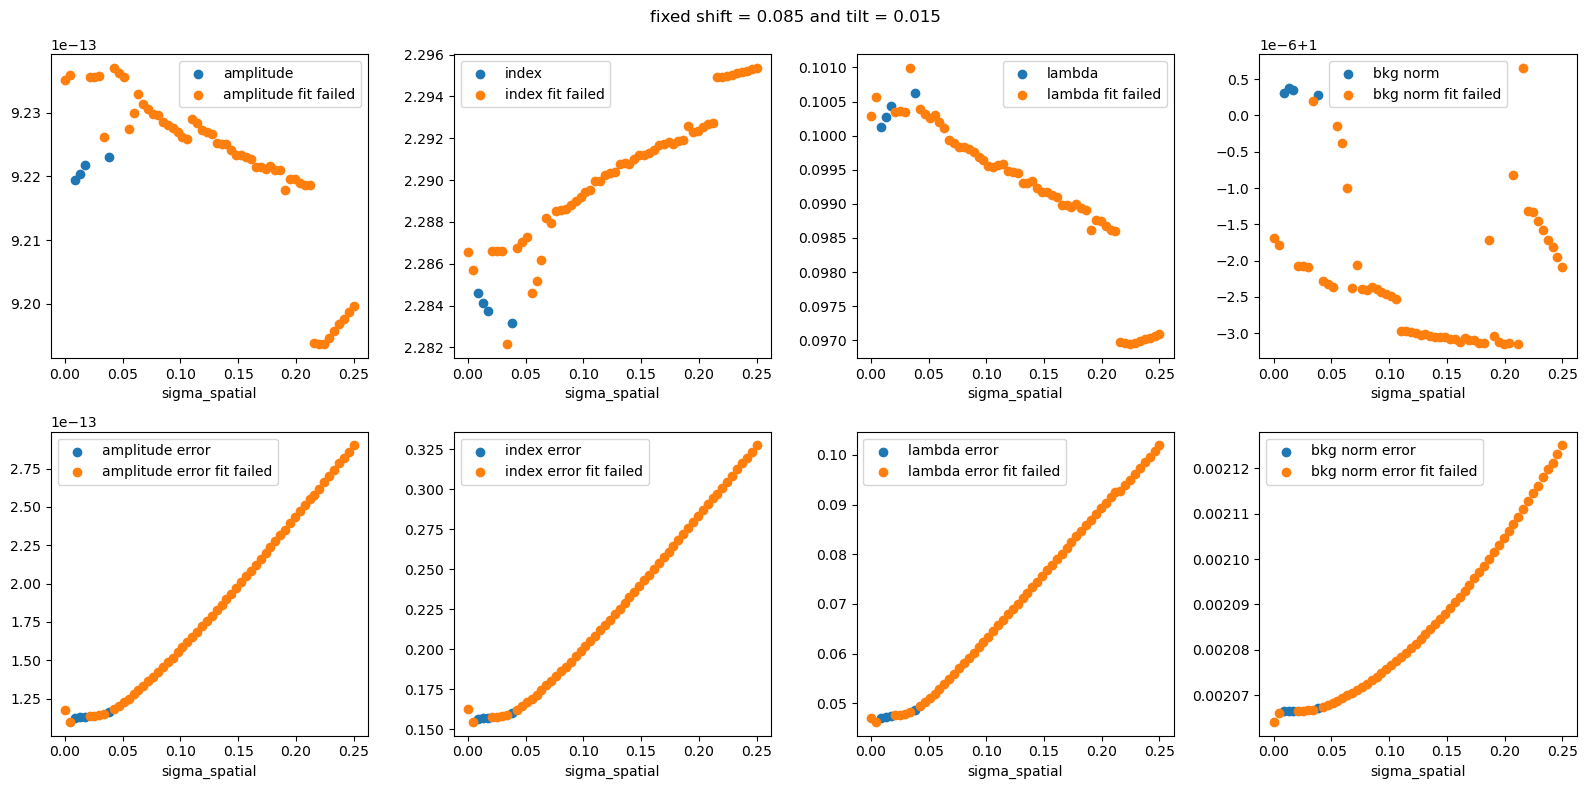

In [6]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

ax[0][0].scatter(*zip(*amplitude_sigma_spatial), label='amplitude')  
ax[0][1].scatter(*zip(*index_sigma_spatial), label='index')
ax[0][2].scatter(*zip(*lambda_sigma_spatial), label='lambda')
ax[0][3].scatter(*zip(*norm_sigma_spatial), label='bkg norm')

ax[1][0].scatter(*zip(*errors_amplitude_sigma_spatial), label='amplitude error')  
ax[1][1].scatter(*zip(*errors_index_sigma_spatial), label='index error')
ax[1][2].scatter(*zip(*errors_lambda_sigma_spatial), label='lambda error')
ax[1][3].scatter(*zip(*errors_norm_sigma_spatial), label='bkg norm error')

if bool(amplitude_sigma_spatial_fail):
    ax[0][0].scatter(*zip(*amplitude_sigma_spatial_fail), label='amplitude fit failed', color='tab:orange')  
    ax[0][1].scatter(*zip(*index_sigma_spatial_fail), label='index fit failed', color='tab:orange')
    ax[0][2].scatter(*zip(*lambda_sigma_spatial_fail), label='lambda fit failed', color='tab:orange')
    ax[0][3].scatter(*zip(*norm_sigma_spatial_fail), label='bkg norm fit failed', color='tab:orange')

    ax[1][0].scatter(*zip(*errors_amplitude_sigma_spatial_fail), label='amplitude error fit failed', color='tab:orange')  
    ax[1][1].scatter(*zip(*errors_index_sigma_spatial_fail), label='index error fit failed', color='tab:orange')
    ax[1][2].scatter(*zip(*errors_lambda_sigma_spatial_fail), label='lambda error fit failed', color='tab:orange')
    ax[1][3].scatter(*zip(*errors_norm_sigma_spatial_fail), label='bkg norm error fit failed', color='tab:orange')

ax[0][0].set_xlabel('sigma_spatial');ax[0][1].set_xlabel('sigma_spatial');ax[0][2].set_xlabel('sigma_spatial');ax[0][3].set_xlabel('sigma_spatial')
ax[1][0].set_xlabel('sigma_spatial');ax[1][1].set_xlabel('sigma_spatial');ax[1][2].set_xlabel('sigma_spatial');ax[1][3].set_xlabel('sigma_spatial')
ax[0][0].legend();ax[0][1].legend();ax[0][2].legend();ax[0][3].legend()
ax[1][0].legend();ax[1][1].legend();ax[1][2].legend();ax[1][3].legend()
plt.suptitle(f'fixed shift = {shift_fixed} and tilt = {tilt_fixed}')
plt.tight_layout()
fig.savefig("plots/1e_varying_sigma_spatial.pdf") 
plt.show()

### With Nuisance

In [7]:
%%time
amplitude_sigma_spatial_N = []
index_sigma_spatial_N = []
lambda_sigma_spatial_N = []
norm_sigma_spatial_N = []
errors_amplitude_sigma_spatial_N = []
errors_index_sigma_spatial_N = []
errors_lambda_sigma_spatial_N = []
errors_norm_sigma_spatial_N = []

amplitude_sigma_spatial_N_fail = []
index_sigma_spatial_N_fail = []
lambda_sigma_spatial_N_fail = []
norm_sigma_spatial_N_fail = []
errors_amplitude_sigma_spatial_N_fail = []
errors_index_sigma_spatial_N_fail = []
errors_lambda_sigma_spatial_N_fail = []
errors_norm_sigma_spatial_N_fail = []

shift_fixed = 0.085
tilt_fixed = 0.015
amplitude = 1e-12

for i, sigma_spatial in enumerate(np.linspace(0.0001, 0.1, 20)):
    
    dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
    # Create the spatial model 
    model_spatial = GaussianSpatialModel(
        lon_0="83.631 deg",
        lat_0="22.018 deg",
        sigma=f"{sigma_spatial} deg",
        )

    # Create the spectral model 
    model_spectrum  = ExpCutoffPowerLawSpectralModel(
        index=2.3,
        amplitude=f"{amplitude} TeV-1 cm-2 s-1",
        lambda_="0.1 TeV-1"
    )

    # combine the spectral and the spatial model
    source_model = SkyModel(spatial_model = model_spatial ,
                           spectral_model = model_spectrum,
                           name = "Source")    
    models = Models(source_model)

    # Create the model for the Background
    bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
    bkg_model.parameters['tilt'].frozen  = False
    models.append(bkg_model)

    # set the models in the dataset
    dataset_asimov.models = models
    # set counts
    dataset_asimov.counts = dataset_asimov.npred()
    
    
    #print('sigma_spatial', i, '=', sigma_spatial)
    sys_d_cor = sys_dataset(dataset_asimov, shift_fixed, tilt_fixed, False, amplitude, sigma_spatial)
    dataset_N = sys_d_cor.create_dataset_N()
    zero = 1e-24
    ## additional parameter bias and resolution (ereco) but are frozen
    penalising_invcovmatrix = np.zeros((4, 4))
    np.fill_diagonal(penalising_invcovmatrix,
                     [1/shift_fixed**2, 1/tilt_fixed**2, 1/zero**2, 1/zero**2])
    
    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_sigma_spatial = dataset_N
    
    fit_sigma_spatial = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_sigma_spatial.backend = "minuit"
    fit_sigma_spatial.optimize_opts = minuit_opts
    result_sigma_spatial = fit_sigma_spatial.run([dataset_sigma_spatial])
    if result_sigma_spatial.success:
        #print(result_sigma_spatial.success)
        amplitude_sigma_spatial_N.append((sigma_spatial, dataset_sigma_spatial.models.parameters['amplitude'].value))
        index_sigma_spatial_N.append((sigma_spatial, dataset_sigma_spatial.models.parameters['index'].value))
        lambda_sigma_spatial_N.append((sigma_spatial, dataset_sigma_spatial.models.parameters['lambda_'].value))
        norm_sigma_spatial_N.append((sigma_spatial, dataset_sigma_spatial.models.parameters['norm'].value))

        errors_amplitude_sigma_spatial_N.append((sigma_spatial, dataset_sigma_spatial.models.parameters['amplitude'].error))
        errors_index_sigma_spatial_N.append((sigma_spatial, dataset_sigma_spatial.models.parameters['index'].error))
        errors_lambda_sigma_spatial_N.append((sigma_spatial, dataset_sigma_spatial.models.parameters['lambda_'].error))
        errors_norm_sigma_spatial_N.append((sigma_spatial, dataset_sigma_spatial.models.parameters['norm'].error))
    else:
        print('Fail')
        amplitude_sigma_spatial_N_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['amplitude'].value))
        index_sigma_spatial_N_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['index'].value))
        lambda_sigma_spatial_N_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['lambda_'].value))
        norm_sigma_spatial_N_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['norm'].value))

        errors_amplitude_sigma_spatial_N_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['amplitude'].error))
        errors_index_sigma_spatial_N_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['index'].error))
        errors_lambda_sigma_spatial_N_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['lambda_'].error))
        errors_norm_sigma_spatial_N_fail.append((sigma_spatial, dataset_sigma_spatial.models.parameters['norm'].error))
    
    
    #print(dataset_sigma_spatial.models.parameters['amplitude'].error)
    #print(dataset_sigma_spatial.models.parameters['index'].error)

Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
CPU times: total: 8h 5min 14s
Wall time: 1h 29min 40s


In [12]:
try:
    np.savetxt('data/1e_amplitude_sigma_spatial_N.txt', amplitude_sigma_spatial_N)
    np.savetxt('data/1e_index_sigma_spatial_N.txt', index_sigma_spatial_N)
    np.savetxt('data/1e_lambda_sigma_spatial_N.txt', lambda_sigma_spatial_N)
    np.savetxt('data/1e_norm_sigma_spatial_N.txt', norm_sigma_spatial_N)
    np.savetxt('data/1e_errors_amplitude_sigma_spatial_N.txt', errors_amplitude_sigma_spatial_N)
    np.savetxt('data/1e_errors_index_sigma_spatial_N.txt', errors_index_sigma_spatial_N)
    np.savetxt('data/1e_errors_lambda_sigma_spatial_N.txt', errors_lambda_sigma_spatial_N)
    np.savetxt('data/1e_errors_norm_sigma_spatial_N.txt', errors_norm_sigma_spatial_N)

    np.savetxt('data/1e_amplitude_sigma_spatial_N_fail.txt', amplitude_sigma_spatial_N_fail)
    np.savetxt('data/1e_index_sigma_spatial_N_fail.txt', index_sigma_spatial_N_fail)
    np.savetxt('data/1e_lambda_sigma_spatial_N_fail.txt', lambda_sigma_spatial_N_fail)
    np.savetxt('data/1e_norm_sigma_spatial_N_fail.txt', norm_sigma_spatial_N_fail)
    np.savetxt('data/1e_errors_amplitude_sigma_spatial_N_fail.txt', errors_amplitude_sigma_spatial_N_fail)
    np.savetxt('data/1e_errors_index_sigma_spatial_N_fail.txt', errors_index_sigma_spatial_N_fail)
    np.savetxt('data/1e_errors_lambda_sigma_spatial_N_fail.txt', errors_lambda_sigma_spatial_N_fail)
    np.savetxt('data/1e_errors_norm_sigma_spatial_N_fail.txt', errors_norm_sigma_spatial_N_fail)
except:
    amplitude_sigma_spatial_N = np.loadtxt('data/1e_amplitude_sigma_spatial_N.txt')
    index_sigma_spatial_N = np.loadtxt('data/1e_index_sigma_spatial_N.txt')
    lambda_sigma_spatial_N = np.loadtxt('data/1e_lambda_sigma_spatial_N.txt')
    norm_sigma_spatial_N = np.loadtxt('data/1e_norm_sigma_spatial_N.txt')
    errors_amplitude_sigma_spatial_N = np.loadtxt('data/1e_errors_amplitude_sigma_spatial_N.txt')
    errors_index_sigma_spatial_N = np.loadtxt('data/1e_errors_index_sigma_spatial_N.txt')
    errors_lambda_sigma_spatial_N = np.loadtxt('data/1e_errors_lambda_sigma_spatial_N.txt')
    errors_norm_sigma_spatial_N = np.loadtxt('data/1e_errors_norm_sigma_spatial_N.txt')

    amplitude_sigma_spatial_N_fail = np.loadtxt('data/1e_amplitude_sigma_spatial_N_fail.txt')
    index_sigma_spatial_N_fail = np.loadtxt('data/1e_index_sigma_spatial_N_fail.txt')
    lambda_sigma_spatial_N_fail = np.loadtxt('data/1e_lambda_sigma_spatial_N_fail.txt')
    norm_sigma_spatial_N_fail = np.loadtxt('data/1e_norm_sigma_spatial_N_fail.txt')
    errors_amplitude_sigma_spatial_N_fail = np.loadtxt('data/1e_errors_amplitude_sigma_spatial_N_fail.txt')
    errors_index_sigma_spatial_N_fail = np.loadtxt('data/1e_errors_index_sigma_spatial_N_fail.txt')
    errors_lambda_sigma_spatial_N_fail = np.loadtxt('data/1e_errors_lambda_sigma_spatial_N_fail.txt')
    errors_norm_sigma_spatial_N_fail = np.loadtxt('data/1e_errors_norm_sigma_spatial_N_fail.txt')

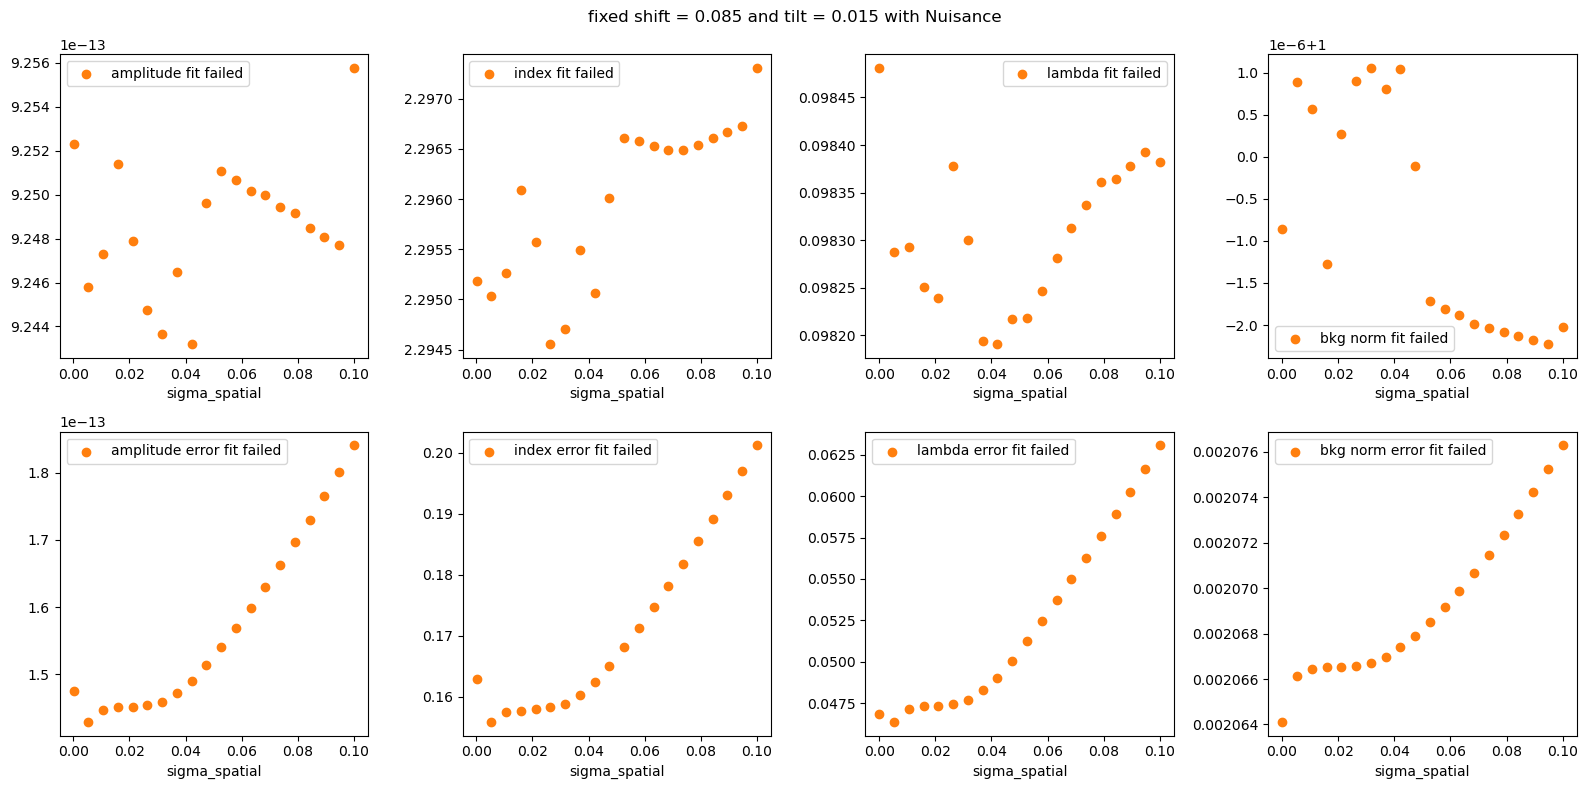

In [11]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

if bool(amplitude_sigma_spatial_N):
    ax[0][0].scatter(*zip(*amplitude_sigma_spatial_N), label='amplitude')  
    ax[0][1].scatter(*zip(*index_sigma_spatial_N), label='index')
    ax[0][2].scatter(*zip(*lambda_sigma_spatial_N), label='lambda')
    ax[0][3].scatter(*zip(*norm_sigma_spatial_N), label='bkg norm')

    ax[1][0].scatter(*zip(*errors_amplitude_sigma_spatial_N), label='amplitude error')  
    ax[1][1].scatter(*zip(*errors_index_sigma_spatial_N), label='index error')
    ax[1][2].scatter(*zip(*errors_lambda_sigma_spatial_N), label='lambda error')
    ax[1][3].scatter(*zip(*errors_norm_sigma_spatial_N), label='bkg norm error')

if bool(amplitude_sigma_spatial_N_fail):
    ax[0][0].scatter(*zip(*amplitude_sigma_spatial_N_fail), label='amplitude fit failed', color='tab:orange')  
    ax[0][1].scatter(*zip(*index_sigma_spatial_N_fail), label='index fit failed', color='tab:orange')
    ax[0][2].scatter(*zip(*lambda_sigma_spatial_N_fail), label='lambda fit failed', color='tab:orange')
    ax[0][3].scatter(*zip(*norm_sigma_spatial_N_fail), label='bkg norm fit failed', color='tab:orange')

    ax[1][0].scatter(*zip(*errors_amplitude_sigma_spatial_N_fail), label='amplitude error fit failed', color='tab:orange')  
    ax[1][1].scatter(*zip(*errors_index_sigma_spatial_N_fail), label='index error fit failed', color='tab:orange')
    ax[1][2].scatter(*zip(*errors_lambda_sigma_spatial_N_fail), label='lambda error fit failed', color='tab:orange')
    ax[1][3].scatter(*zip(*errors_norm_sigma_spatial_N_fail), label='bkg norm error fit failed', color='tab:orange')

ax[0][0].set_xlabel('sigma_spatial');ax[0][1].set_xlabel('sigma_spatial');ax[0][2].set_xlabel('sigma_spatial');ax[0][3].set_xlabel('sigma_spatial')
ax[1][0].set_xlabel('sigma_spatial');ax[1][1].set_xlabel('sigma_spatial');ax[1][2].set_xlabel('sigma_spatial');ax[1][3].set_xlabel('sigma_spatial')
ax[0][0].legend();ax[0][1].legend();ax[0][2].legend();ax[0][3].legend()
ax[1][0].legend();ax[1][1].legend();ax[1][2].legend();ax[1][3].legend()
plt.suptitle(f'fixed shift = {shift_fixed} and tilt = {tilt_fixed} with Nuisance')
plt.tight_layout()
fig.savefig("plots/1e_varying_sigma_spatial_nuisance.pdf") 
plt.show()